# Naive Bayes Classifier 

## Part A: Model Code

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer , PorterStemmer
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zedin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1. Implement a Multinomial_NB model class. It should have the methods __init__, fit(self,X,Y), precit(self,X), and predict_log_proba(self,X). predict_proba is implemented as extra credit

In [2]:

class Multinomial_NB:
    def __init__(self,alpha = 1.0):
        self.alpha = alpha

    def fit(self,X,Y,alpha=1.0):
        self.alpha = alpha
        #self.pie_1 = (Y.sum() + 1 ) / (len(set(Y)) + len(Y))
        self.pie_1 = (Y.sum() + self.alpha ) / (len(set(Y))*self.alpha + len(Y))

        self.theta_jc = np.zeros((2, X.shape[1]))
        ham_doc = X[Y == 0]
        #self.theta_jc[0] = (ham_doc.sum(axis=0) + 1) / (np.einsum('ij->',ham_doc) + X.shape[1])
        self.theta_jc[0] = (ham_doc.sum(axis=0) + self.alpha) / (np.einsum('ij->',ham_doc) + X.shape[1]*self.alpha)

        spam_doc = X[Y == 1]
        #self.theta_jc[1] = (spam_doc.sum(axis=0)+1) / (np.einsum('ij->',spam_doc)+X.shape[1])
        self.theta_jc[1] = (spam_doc.sum(axis=0)+self.alpha) / (np.einsum('ij->',spam_doc)+X.shape[1]*self.alpha)

    def predict(self,X):
        return np.argmax(self.predict_log_proba(X), axis=1)

    def predict_log_proba(self, X):
        return np.sum(X[:,None] * np.log(self.theta_jc), axis=-1) + np.log([1-self.pie_1,self.pie_1])
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

## Part B: Exploratory Data Analysis. 

2. Read in SMSSpamCollection.csv as a pandas data frame (here it is dataset.csv)

In [3]:
df = pd.read_csv("data/dataset.csv", names = ["spam", "text"])
df.head()

,spam,text
0,spam,text
1,ham,"Go until jurong point, crazy.. Available only ..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,ham,U dun say so early hor... U c already then say...


3. Use the techniques from the first recitation to summarize each of the variables in the dataset in terms of mean, standard deviation, and quartiles.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5575 entries, 0 to 5574
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5575 non-null   object
 1   text    5575 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (5575, 2)

No. of Rows: 5575
No. of Columns: 2


In [6]:
df.groupby('spam').count()

,text
spam,
ham,4827
spam,748


In [7]:
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('spam').length.describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
ham,4827.0,71.450590,58.313071,2.0,33.00,52.0,93.0,910.0
spam,748.0,138.490642,29.271405,4.0,132.75,149.0,157.0,223.0


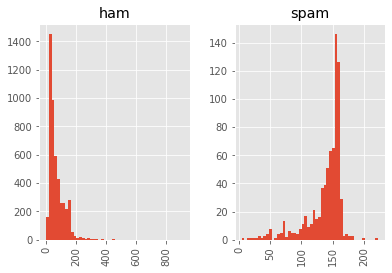

In [8]:
emails_subset = df[df.length < 1800]
emails_subset.hist(column='length', by='spam', bins=50);

4. Generate a bar plot to display the class distribution. You may use “seaborn”s barplot function.

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


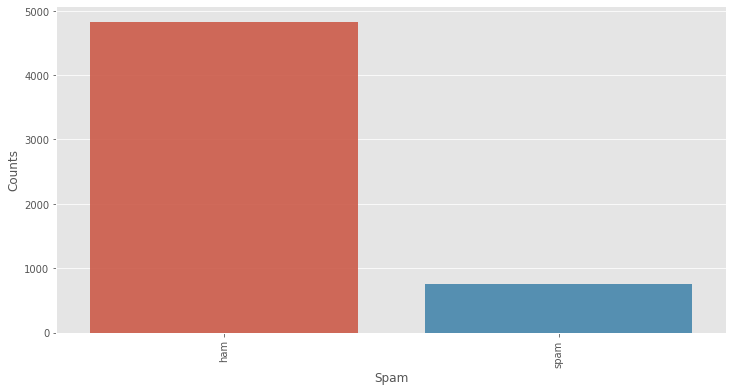

In [9]:
label_counts = df.spam.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Part C: Feature Extraction

5. Normalize the “text” by performing stemming and lemmatization. You should do
experimentation with both stemming and lemmatization and see whether
stemming/lemmatization or a combination of both improves the accuracy of
classification. Finally use the best performing normalization. For text
normalization you may use the NLTK library.

In [10]:
df.spam.replace(('ham', 'spam'), (0, 1), inplace=True)

In [11]:
df

,spam,text,length
0,1,text,4
1,0,"Go until jurong point, crazy.. Available only ...",111
2,0,Ok lar... Joking wif u oni...,29
3,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
4,0,U dun say so early hor... U c already then say...,49
...,...,...,...
5570,1,This is the 2nd time we have tried 2 contact u...,160
5571,0,Will ü b going to esplanade fr home?,36
5572,0,"Pity, * was in mood for that. So...any other s...",57
5573,0,The guy did some bitching but I acted like i'd...,125


9. Shuffle the rows of your data, using df= df.sample(frac=1). Placed out of order for usability reasons.

In [12]:
df = df.sample(frac=1)

In [13]:
%%time
##Lemmatization


lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

Wall time: 2.06 s


In [14]:
%%time
##Stemming
stemmer = PorterStemmer()
df['text_steam'] = df['text'].map(lambda text: ' '.join(stemmer.stem(w) for w in nltk.word_tokenize(text.lower())))

Wall time: 1.63 s


6. Generate word clouds for both the spam and ham emails. You may use the NLTK library

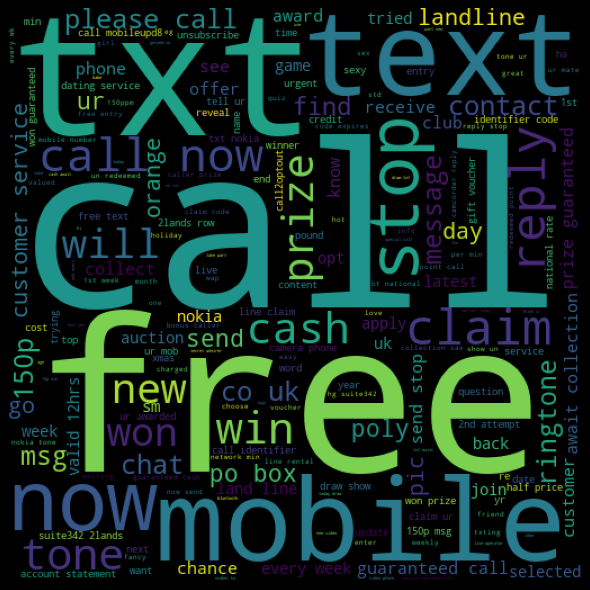

In [15]:
spam_words = ''.join(list(df[df['spam']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


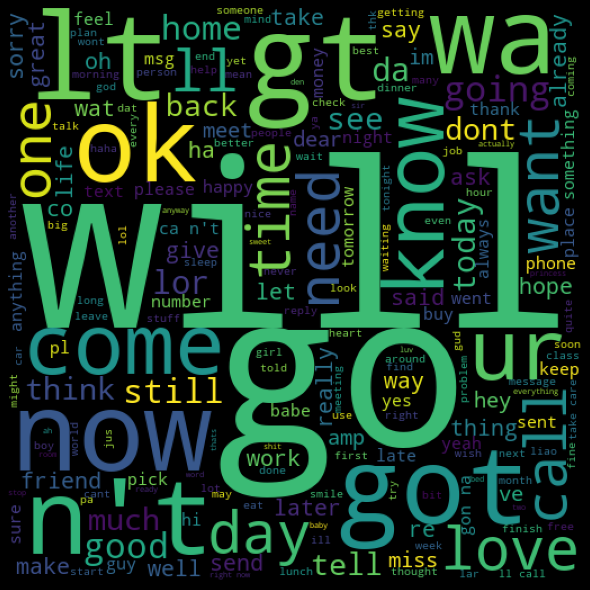

In [16]:
spam_words = ''.join(list(df[df['spam']==0]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

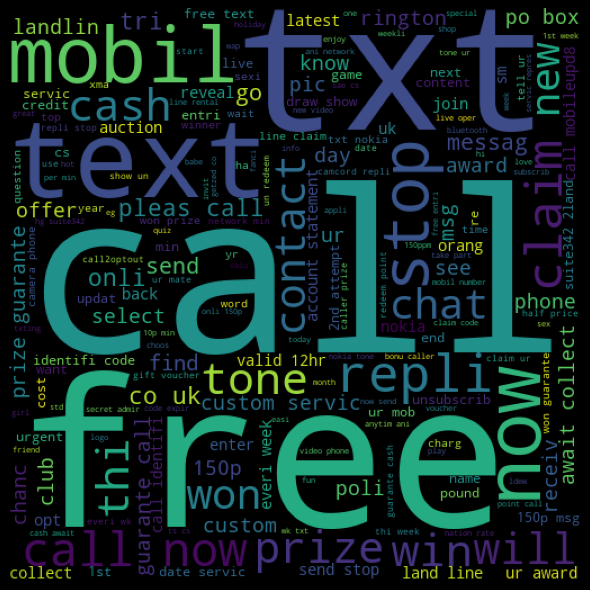

In [17]:
spam_words = ''.join(list(df[df['spam']==1]['text_steam']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

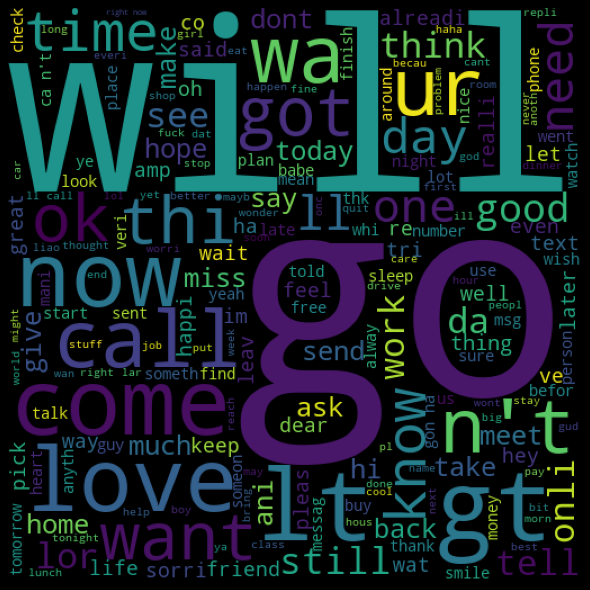

In [18]:
spam_words = ''.join(list(df[df['spam']==0]['text_steam']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

7. Remove the stop words from the text and convert the text content into numerical
feature vectors. Note that for the multinomial Naïve Bayes classifier you need to
count word occurrences as feature values. You may use Scikit-Learn’s
CountVectorizer object for text preprocessing and feature vectorization. 

In [19]:
X = df["text_lemmatized"]
y = df['spam']

In [20]:
count_vect_multinom = CountVectorizer(lowercase=True, stop_words='english',binary = False)
count_vect_multivar = CountVectorizer(lowercase=True, stop_words='english',binary = True)

In [21]:
X_counts_nom = count_vect_multinom.fit_transform(X)
X_counts_var = count_vect_multivar.fit_transform(X)

8. Create data or feature matrix X and the target vector Y. The number of columns in X is equal to the number of features.

In [22]:
y = np.array(y)
X_nom = np.array(X_counts_nom.toarray())
X_var = np.array(X_counts_var.toarray())

In [23]:

def mse(Y_true, Y_pred):
    E = np.array(Y_true).reshape(-1,1) - np.array(Y_pred).reshape(-1,1)
    mse = 1/np.array(Y_true).shape[0] * (E.T.dot(E))
    return mse[(0,0)]

def accuracy(x,y):
    x,y = np.array(x),np.array(y)
    pred = (x == y).astype(np.int)
    return pred.mean()

10. Partition the data into train and test set (80%-20%). Use the “Partition” function from your previous assignment. "Partition" in our case is split_trainTest

In [24]:
def split_trainTest(X,y,t):
    train_size = int((1-t) * X.shape[0])   
    return X[:train_size],X[train_size:],y[:train_size],y[train_size:]



In [25]:
X_train, X_test, y_train, y_test = split_trainTest(X_var,y,t=0.2)

## Part D: Model Evaluation.

11. Model selection via Hyper-parameter tuning: Use the kFold function from the
previous assignment to evaluate the performance of your model for the following
values of the hyperparameter alpha = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0].
Determine the best model (model selection) based on the overall performance
(lowest average error). For the error_function of the kFold function argument use
the “F1 Score” function from previous assignment. 
In our case we use our own sFold function rather than kFold

In [26]:
def sFold(folds,data,labels,model,error_fuction,**model_args):
#def sFold(folds,data,labels,model,error_fuction,**model_args):
    if(labels.shape == (labels.shape[0],)):
        labels = np.expand_dims(labels,axis=1)
    dataset = np.concatenate([data,labels],axis=1)
    s_part = s_partition(dataset,folds)
    pred_y = []
    true_y = []
    for idx,val in enumerate(s_part):
        test_y = val[:,-1]
        #test_y = np.expand_dims(test_y, axis=1)
        test = val[:,:-1]
        train = np.concatenate(np.delete(s_part,idx,0))
        label = train[:,-1]
        train = train[:,:-1]        
        model.fit(train,label,**model_args)       
        pred = model.predict(test)
        pred_y.append(pred)
        true_y.append(test_y)
    pred_y = np.concatenate(pred_y)
    true_y = np.concatenate(true_y)

    avg_error = error_fuction(pred_y,true_y).mean()   
    result = {'Expected labels':true_y, 'Predicted labels': pred_y,'Average error':avg_error }
    return result


#helper
def s_partition(x,s):
    return np.array_split(x,3)

14. EXTRA CREDIT:  Implement the Multivariate Bernoulli
Naïve Bayes model. The hyperparameter should be the Additive or Laplace
smoothing parameter alpha. Using cross-validation determine the best model.
Evaluate your model on test data as specified in the previous question. 

In [27]:

class Multivariate_NB:
    def __init_(self,alpha = 1.0):
        self.alpha = alpha
        self.pie_1 = None
        self.pie_0 = None
        self.theta_jc_1 = None
        self.theta_jc_0 = None
    
    def fit(self,X,Y):
        pie_num = (Y == 1).astype(int).sum() + 1 
        pie_denum = len(set(Y)) + len(Y)
        self.pie_0 = pie_num / pie_denum       
        self.pie_1 = 1 - self.pie_0
        
        
        N_jc_0 =  X[Y == 0].sum(axis=0) 
        N_c_0 = X[Y==0].shape[0]
        self.theta_jc_0 = (N_jc_0 + 1) / (2 + N_c_0)
        
        N_jc_1 =  X[Y == 1].sum(axis=0) 
        N_c_1 = X[Y==1].shape[0]
        self.theta_jc_1 = (N_jc_1 + 1) / (2 + N_c_1)                   
    def predict(self,X):
        return np.argmax(self.predict_log_proba(X), axis=1)
        
    def predict_log_proba(self, X):
        a = self.theta_jc_1[:,None]
        b = self.theta_jc_0[:,None]
        log_prob_1 = np.log(self.pie_1) + np.log(np.where(X.T*a != 0,a, 1-a )).sum(axis=0).T
        log_prob_1 = log_prob_1[:,None]
        log_prob_0 = np.log(self.pie_0) + np.log(np.where(X.T*b != 0,b, 1-b )).sum(axis=0).T
        log_prob_0 = log_prob_0[:,None]
        return np.concatenate((log_prob_0,log_prob_1),axis = 1)
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))

In [28]:
model = Multivariate_NB()
model.fit(X_train,y_train)
y_pre = model.predict(X_test)
mse(y_test, y_pre)
accuracy(y_test, y_pre)

0.9757847533632287

Bernoulli Naive Bayes from sklearn for comparison.

In [29]:

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train,y_train)
y_pre_sk = clf.predict(X_test)
print(y_pre_sk)
mse(y_test, y_pre_sk)
accuracy(y_test, y_pre_sk)

[0 0 1 ... 0 0 0]


0.9757847533632287

In [30]:
X_train, X_test, y_train, y_test = split_trainTest(X_nom,y,t=0.2)

In [31]:
model = Multinomial_NB()
model.fit(X_train,y_train)
y_pre = model.predict(X_test)
y_pre
mse(y_test, y_pre)


0.023318385650224215

Multinomial Naive Bayes from sklearn for comparison.

In [32]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pre_sk = clf.predict(X_test)
y_pre_sk
mse(y_test, y_pre_sk)

0.023318385650224215

In [33]:
validation_accuracy = np.empty((4,2,2))
validation_accuracy

array([[[1.65783043e-309, 3.43094890e-309],
        [4.34332221e-309, 5.00184116e-309]],

       [[5.76510183e-309, 6.65160801e-309],
        [7.18000618e-309, 7.80124167e-309]],

       [[8.35501891e-309, 8.76891419e-309],
        [9.30414519e-309, 9.47112504e-309]],

       [[9.47112504e-309, 9.47112504e-309],
        [9.47112504e-309, 9.47112504e-309]]])

Functions from previous assignments to evaluate our model on test data in question 13.

In [34]:
def compute_recall(actual, predicted):
    
    CM =  compute_confusion_matrix(actual, predicted).to_numpy()  # CM is converted into a 2 X 2 array.
    
    TN = CM[0,0]; FP = CM[0,1]; FN = CM[1,0]; TP =  CM[1,1];
    
    recall = TP / (TP + FN)
    
    return recall

def compute_confusion_matrix(actual, predicted):
    
    arary_actual = np.array(actual)
    array_pred = np.array(predicted)
    
    pd_actual = pd.Series(arary_actual, name='Actual')
    pd_predicted = pd.Series(array_pred, name='Predicted')

    pd_actual = pd.Categorical(pd_actual, categories=[0, 1])
    pd_predicted = pd.Categorical(pd_predicted, categories=[0, 1])

    CM =  pd.crosstab(pd_actual, pd_predicted, dropna=False)
    
    return CM

def compute_precision(actual, predicted):
       
    CM =  compute_confusion_matrix(actual, predicted).to_numpy()  # CM is converted into a 2 X 2 array.
    
    TN = CM[0,0]; FP = CM[0,1]; FN = CM[1,0]; TP =  CM[1,1];
    
    precision = TP / (TP + FP)
    
    return precision

In [35]:
def compute_F1_score(actual, predicted):
    
    precision = compute_precision(actual, predicted)
    recall = compute_recall(actual, predicted)
    
    F1_score = 2 * precision * recall / (precision + recall)
    
    return F1_score

In [36]:
validation_accuracy = np.empty((8,1))
alpha = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
maxScore = 0
for i,k in enumerate(alpha):
    multi_nom = Multinomial_NB()
    model_args = {'alpha' : k}
    result = sFold(5,X_train,y_train,multi_nom,compute_F1_score,**model_args)
    validation_accuracy[i] = result['Average error']
    if validation_accuracy[i] > maxScore:
        maxScore = validation_accuracy[i]
        index = i

c:\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Best model determined in previous cell, then optimal printed here. 

In [37]:
print('optimal alpha: ',alpha[index])

optimal alpha:  1.0


F1 score here

In [38]:
model = Multinomial_NB()
model.fit(X_train,y_train,alpha = 2)
y_pre = model.predict(X_test)
y_pre
compute_F1_score(y_test, y_pre)

0.9278350515463918

13. Evaluate your model on the test data and report the following performance
measures. You may reuse the functions from your previous assignment

In [39]:
print('Testing on Test DATA')
print('Precision :',compute_precision(y_test, y_pre))
print('Recall :',compute_recall(y_test, y_pre))
print('F1 Score :',compute_F1_score(y_test, y_pre))
print('\n\nConfusion Matrix :\n')
print(compute_confusion_matrix(y_test, y_pre))
print('\n\nAccuracy :',accuracy(y_test, y_pre))

Testing on Test DATA
Precision : 0.9183673469387755
Recall : 0.9375
F1 Score : 0.9278350515463918


Confusion Matrix :

col_0    0    1
row_0          
0      959   12
1        9  135


Accuracy : 0.9811659192825112


12. EXTRA CREDIT: Generate the Receiver
Operating Characteristic (ROC) curve and compute the area under curve (AUC)
score. You may reuse the functions from previous assignment.

In [40]:
def generate_ROC_elements(y_label, y_prob, target_label = 1):
    
    # gets the target label.
    if target_label == 0: non_target_label = 1
    if target_label == 1: non_target_label = 0
    
    # converts the input arguments into arrays.
    ar_y_label = np.array(y_label)
    ar_y_prob = np.array(y_prob)
    
    # creates a list to sort the results of predicted y. 
    y_pred = list(y_prob)
    
    # generates list to store the tpr, fpr and threshold.
    tpr_list = [0, 1]     
    fpr_list = [0, 1]
    thres_lish = [1, 0]
    
    # using the for loop to predicte y based on the input y_prob. 
    for i, prob in enumerate(ar_y_prob):
        threshold = prob
        for index, y_prob in enumerate(ar_y_prob):
            if y_prob >= threshold:
                y_pred[index] = target_label
            else:
                y_pred[index] = non_target_label
        
        # uses the function to compute the confusion matrix, and gets the TN, FP, FN, TP. 
        CM = compute_confusion_matrix(y_label, y_pred).to_numpy()           
        TN = CM[0,0]; FP = CM[0,1]; FN = CM[1,0]; TP =  CM[1,1]
        
        # Calculates tpr and fpr. 
        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)
    
        # adds the tpr, fpr and threshold into the corresponding lists. 
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        thres_lish.append(threshold)

    # when the for loop is end, generating a dataframe with the lists of threshold, fpr and tpr. 
    data = {'threshold':pd.Series(thres_lish), 'fpr':pd.Series(fpr_list), 'tpr':pd.Series(tpr_list)}
    df_roc = pd.DataFrame(data)
    
    # descending sorting the dataframe according to the threshold column
    df_roc.sort_values(by='threshold', ascending=False, inplace=True)
    
    return np.array(df_roc["fpr"]), np.array(df_roc["tpr"])

def plotting_roc_curve(fpr, tpr, label = None): 
    plt.figure(figsize = (10, 10))
    
    # linewidth and fontsize
    lw = 2
    fontsize = 20
    
    # plot roc curve
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = label) 
    
    # plot y = x
    plt.plot([0, 1], [0, 1], color='navy', lw = lw, linestyle = '--')  
    
    # set the length of x axis and y axis. 
    plt.axis([0, 1, 0, 1.05])
    
    # add title, xlabel, ylabel, and legend. 
    plt.title(f'Receiver operating characteristic Curve ({label})', fontsize = fontsize)
    plt.xlabel('False Positive Rate', fontsize = fontsize)
    plt.ylabel('True Positive Rate', fontsize = fontsize)
    plt.legend(loc="lower right", fontsize = fontsize)
    
    plt.show()

def generate_precision_recall_curve_elements(y_label, y_prob, target_label = 1):
    
    # gets the target label.
    if target_label == 0: non_target_label = 1
    if target_label == 1: non_target_label = 0
    
    # converts the input arguments into arrays.
    ar_y_label = np.array(y_label)
    ar_y_prob = np.array(y_prob)
    
    # creates a list to sort the results of predicted y. 
    y_pred = list(y_prob)
    
    # generates list to store the tpr, fpr and threshold.
    precision_list = []     
    recall_list = []
    thres_lish = []
    
    # using the for loop to predicte y based on the input y_prob. 
    
    for i, prob in enumerate(ar_y_prob):
        threshold = prob
        for index, y_prob in enumerate(ar_y_prob):
            if y_prob >= threshold:
                y_pred[index] = target_label
            else:
                y_pred[index] = non_target_label
        
        # uses the function to compute the confusion matrix, and gets the TN, FP, FN, TP. 
        CM = compute_confusion_matrix(y_label, y_pred).to_numpy()           
        TN = CM[0,0]; FP = CM[0,1]; FN = CM[1,0]; TP =  CM[1,1]
        
        # Calculates tpr and fpr. 
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
    
        # adds the tpr, fpr and threshold into the corresponding lists. 
        precision_list.append(precision)
        recall_list.append(recall)
        thres_lish.append(threshold)

    # when the for loop is end, generating a dataframe with the lists of threshold, fpr and tpr. 
    data = {'threshold':pd.Series(thres_lish), 'precision':pd.Series(precision_list), 'recall':pd.Series(recall_list)}
    df_roc = pd.DataFrame(data)
    
    # descending sorting the dataframe according to the threshold column
    df_roc.sort_values(by='threshold', ascending = True, inplace = True)
        
    return np.array(df_roc["precision"]), np.array(df_roc["recall"]), np.array(df_roc["threshold"]) 

def calculate_auc(fpr_x_axis, tpr_y_axis):
    
    # Trapezoidal numerical integration 
    auc = np.trapz(tpr_y_axis, fpr_x_axis)
    
    return auc

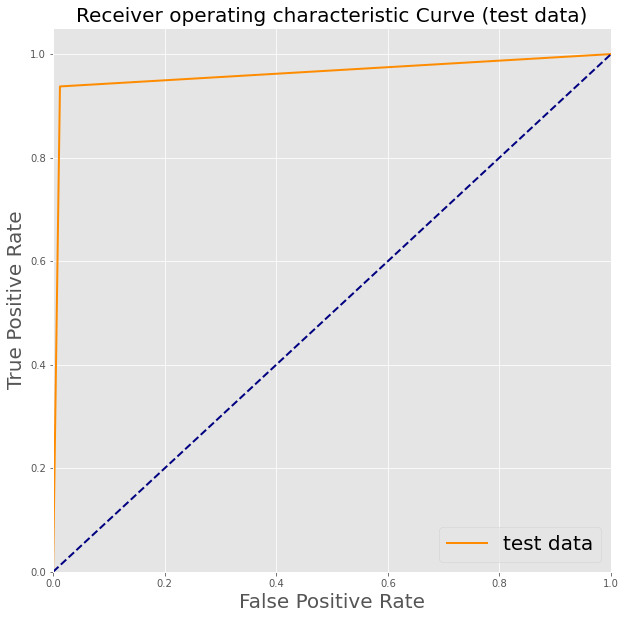



AUC : 0.9625708032955717


In [41]:
fpr, tpr = generate_ROC_elements(y_test, y_pre)
plotting_roc_curve(fpr, tpr, "test data")
print('\n\nAUC :',calculate_auc(fpr, tpr))

# Logistic Regression: Multi-Class Classification
This will use Iris dataset for multi-class classification.

## Part A: Model Code
Design a Softmax Regression classifier for performing multi-class classification on the Iris dataset.

In [42]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris()
data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [43]:
y = data.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

15. Implement the following function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. function: one_hot_labels(Y).

In [44]:
# #15
def one_hot_labels(Y):
    list_y = list(set(Y))
    n_cols = len(list_y)
    n_rows = Y.shape[0]
    Y_one_hot = np.zeros((n_rows, n_cols))
    for i, vale in enumerate(Y):
        Y_one_hot[i][list_y.index(vale)] = 1
    return Y_one_hot

In [45]:
one_hot_labels(y)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

16. Implement the following function that computes the softmax score or the normalized exponential of the score of a feature.
function: softmax(score)

In [46]:
# #16
def softmax_a(score):
    Y_prob = np.zeros((score.shape))
    for i in range(0,score.shape[0]):
        Y_prob[i] = np.exp(score[i]) / np.sum(np.exp(score[i]), axis=0)
    return Y_prob

In [47]:
# example from sklearn 

x = np.array([[1, 0.5, 0.2, 3],
              [1,  -1,   7, 3],
              [2,  12,  13, 3]])

from scipy.special import softmax
m = softmax(x, axis=1)
m

array([[1.05877070e-01, 6.42176889e-02, 4.75736340e-02, 7.82331607e-01],
       [2.42746030e-03, 3.28521027e-04, 9.79307378e-01, 1.79366403e-02],
       [1.22093673e-05, 2.68929212e-01, 7.31025390e-01, 3.31885014e-05]])

In [48]:
# testing with our function
softmax_a(x)

array([[1.05877070e-01, 6.42176889e-02, 4.75736340e-02, 7.82331607e-01],
       [2.42746030e-03, 3.28521027e-04, 9.79307378e-01, 1.79366403e-02],
       [1.22093673e-05, 2.68929212e-01, 7.31025390e-01, 3.31885014e-05]])

17. Implement the following function to compute the cross-entropy loss. function: cross_entropy_loss(Y_one_hot, Y_proba)

In [49]:
# #17 
def cross_entropy_loss(Y_one_hot, Y_proba):
    
    # it can't work if there are 0 in the Y_proba.
    all_loss = -(Y_one_hot * np.log(Y_proba)).sum(axis=1)
    
    return np.average(all_loss)

In [50]:
# example from sklearn 
from sklearn.metrics import log_loss
y_pred = np.array([[.1, .9], [.9, .1], [.8, .2], [0.99, 0.01]])
# y_pred_0 = np.array([[.1, .9], [.9, .1], [.8, .2], [1, 0]])
x = np.array([1, 0, 0, 1])
log_loss(x, y_pred)
# log_loss(x, y_pred_0)

1.2597586921544883

In [51]:
# testing with our function
Y_one_hot = one_hot_labels(x)
cross_entropy_loss(Y_one_hot, y_pred)
# cross_entropy_loss(Y_one_hot, y_pred_0) # it can't work

1.2597586921544883